In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import warnings

warnings.filterwarnings("ignore")

SEED = 42

In [2]:
import torch
import pickle
import pandas as pd
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sentence_transformers import SentenceTransformer
from sklearn.base import clone

In [3]:
print(f"pytorch version: {torch.__version__}")
print(f"cuda available: {torch.cuda.is_available()}")
print(f"devices count: {torch.cuda.device_count()}")

pytorch version: 2.1.2+cu118
cuda available: True
devices count: 4


In [4]:
#Needed for MLP
def balance_dataset(X, y): 
    value_counts = []
    for i in range(5):
        value_counts.append(y.count(i))
    index = 0
    added = {1: 0, 2: 0, 3: 0, 4: 0}
    add_to_y = {1: [], 2: [], 3: [], 4: []}
    add_to_X = {1: [], 2: [], 3: [], 4: []}
    while sum(added.values()) + sum(value_counts) < 5 * value_counts[0]:
        if index >= len(y):
            index = 0
        if y[index] != 0 and added[y[index]] + value_counts[y[index]] < value_counts[0]:
            add_to_y[y[index]].append(y[index])
            add_to_X[y[index]].append(X[index])
            added[y[index]] += 1
        index += 1
    new_X = X.copy()
    new_y = y.copy()
    index = 0
    while index < sum(added.values()):
        for i in range(1, 5):
            if len(add_to_y[i]) > 0:
                new_y.append(add_to_y[i].pop(0))
                new_X.append(add_to_X[i].pop(0))
                index += 1
    return new_X, new_y

In [5]:
def embedJsonLInputFile(model, path):
    input = pd.read_json(path, lines=True).set_index('id')
    e = pd.DataFrame(index=input.index, columns=['Embedding'])
    for idx in tqdm(input.index):
        sentence = input.loc[idx]['text']
        e.loc[idx]['Embedding'] = model.encode(sentence)
    return e

In [15]:
def output_st1(predictions):
    #list with columns ["id": ..., "A001": "1.0, "A002": 0.0, "A003": ..., ..., "A012": ...] 
    QUANT_TO_QUAL={0: 0, 1: 1, 2: 1, 3: 1, 4: 1}
    NUMBER_TO_LABEL={0: "0-Kein", 1: "1-Gering", 2: "2-Vorhanden", 3: "3-Stark", 4: "4-Extrem"}
    
    #predictions_quant: pd.DataFrame = predictions.applymap(lambda x: LABEL_VALS_QUANT[x] if not pd.isna(x) else x)
    predictions_qual: pd.DataFrame = predictions.applymap(lambda x: QUANT_TO_QUAL[x] if not pd.isna(x) else x)
    
    output = pd.DataFrame(index=["id"])
    output.index = predictions.index
    
    #create expected columns
    output["bin_maj"] = predictions_qual.mode(axis='columns')[0]
    output["bin_one"] = predictions_qual.apply(lambda x: (x == 1).any(), axis='columns')
    output["bin_all"] = predictions_qual.apply(lambda x: not (x == 0).any(), axis='columns')
    output["multi_maj"] = predictions.mode(axis='columns')[0].apply(lambda x: NUMBER_TO_LABEL[x])
    output["disagree_bin"] = output.apply(lambda x: x["bin_one"] and not x["bin_all"], axis='columns')
    
    #convert False/True to 0/1
    output['bin_maj'] = output['bin_maj'].apply(lambda x: 1 if x else 0)
    output['bin_one'] = output['bin_one'].apply(lambda x: 1 if x else 0)
    output['bin_all'] = output['bin_all'].apply(lambda x: 1 if x else 0)
    output['disagree_bin'] = output['disagree_bin'].apply(lambda x: 1 if x else 0)

    return output

In [7]:
embedders = [
    #{'model': 'intfloat/multilingual-e5-small', 'model_ident': 'me5-small'},
    #{'model': 'intfloat/multilingual-e5-base', 'model_ident': 'me5-base'},
    {'model': 'intfloat/multilingual-e5-large', 'model_ident': 'me5-large'},
    {'model': 'deutsche-telekom/gbert-large-paraphrase-cosine', 'model_ident': 't-gbert-lpc'}
]

classifiers = [
    {
        'model': SVC(kernel='rbf', C=5, class_weight="balanced", random_state=SEED), 
        'model_ident': 'svc', 
        'prerun': None,
        'param_grid': {'C': [1, 2, 5, 8, 13, 21, 35, 56, 91]}
    }, {
        'model': RandomForestClassifier(class_weight="balanced", criterion="gini", random_state=SEED), 
        'model_ident': 'rfc', 
        'prerun': None,
        'param_grid': {'max_depth': [1, 2, 5, 8, 13, 21, 35, 56, 91], 'n_estimators': [10, 20, 50, 80, 130, 210, 350, 560]}
    }, {
        'model': MLPClassifier(early_stopping=True, n_iter_no_change=10, random_state=SEED, max_iter=1000), 
        'model_ident': 'mlp', 
        'prerun': balance_dataset,
        'param_grid': {'hidden_layer_sizes': [(64,), (128,), (256,), (512,), (1024,), (1536,), (2048,)]}
    }
]

annotators = ["A001", "A002", "A003", "A004", "A005", "A007", "A008", "A009", "A010", "A012"]

In [8]:
annotator_model_scores = {}
models = {}

for embedder in embedders:
    print(f"Embedding Model: {embedder['model_ident']}")

    annotator_model_scores[embedder["model_ident"]] = {}
    models[embedder["model_ident"]] = {}
    
    embeddings = 0
    embedding_model = SentenceTransformer(embedder['model'])
    
    if os.path.isfile(f"data/embeddings/{embedder['model_ident']}.pkl"):
        embeddings = pd.read_pickle(f"data/embeddings/{embedder['model_ident']}.pkl")
    else:
        embeddings = embedJsonLInputFile(embedding_model, 'data/training/X_all.jsonl')
        embeddings.to_pickle(f"data/embeddings/{embedder['model_ident']}.pkl")

    embedding_dim = len(embeddings.iloc[0])

    for classifier in classifiers:
        print(f"Classification Model: {classifier['model_ident']}")

        annotator_model_scores[embedder['model_ident']][classifier['model_ident']] = {}
        models[embedder['model_ident']][classifier['model_ident']] = {}

        
        for annotator in annotators:
            score = 0
            print(f"Annotator: {annotator}")
            
            y_train = pd.read_json(f"data/training/y_train_{annotator}.jsonl", lines=True).set_index('id')
            X_train = embeddings.loc[y_train.index]
            
            y_val = pd.read_json(f"data/training/y_val_{annotator}.jsonl", lines=True).set_index('id')
            X_val = embeddings.loc[y_val.index]

            models[embedder['model_ident']][classifier['model_ident']][annotator] = clone(classifier['model'])
            classifier_model = models[embedder['model_ident']][classifier['model_ident']][annotator]

            cached = False
            with open(f"data/cache.txt", 'r') as f:
                lines = f.readlines()
                for line in lines:
                    if line.strip() == f"{embedder['model_ident']}_{classifier['model_ident']}_{annotator}":
                        cached = True
                        break
            f.close()
            if not cached:
                clf = GridSearchCV(classifier_model, classifier['param_grid'], n_jobs=100, cv=5, refit=True)
                
                X_train_list = X_train['Embedding'].to_list()
                y_train_list = y_train[annotator].to_list()
    
                if classifier["prerun"] is not None:
                    X_train_list, y_train_list = classifier["prerun"](X_train_list, y_train_list)
    
                X_val_list = X_val['Embedding'].to_list()
                y_val_list = y_val[annotator].to_list()
    
                clf.fit(X_train_list, y_train_list)    
                print(clf.best_params_)
                score = clf.score(X_val_list, y_val_list)

                with open(f"data/models/{embedder['model_ident']}_{classifier['model_ident']}_{annotator}.pkl", 'w+b') as f:
                    pickle.dump(clf.best_estimator_, f)
                f.close()
                with open(f"data/cache.txt", 'a') as f:
                    f.write(f"{embedder['model_ident']}-{classifier['model_ident']}-{annotator}\n")
                f.close()    
            else:
                with open(f"data/models/{embedder['model_ident']}_{classifier['model_ident']}_{annotator}.pkl", 'rb') as f:
                    cached_model = pickle.load(f)
                f.close()    
                print(f"Cached: {cached_model}")
                score = cached_model.score(X_val_list, y_val_list)
            
            print(score)
            annotator_model_scores[embedder['model_ident']][classifier['model_ident']][annotator] = score     

Embedding Model: me5-large
Classification Model: svc
Annotator: A001
{'C': 2}
0.54
Annotator: A002
{'C': 91}
0.7091666666666666
Annotator: A003
{'C': 13}
0.6209677419354839
Annotator: A004
{'C': 21}
0.6513409961685823
Annotator: A005
{'C': 13}
0.5859872611464968
Annotator: A007
{'C': 21}
0.5938697318007663
Annotator: A008
{'C': 91}
0.6843501326259946
Annotator: A009
{'C': 56}
0.596551724137931
Annotator: A010
{'C': 91}
0.62
Annotator: A012
{'C': 91}
0.5966666666666667
Classification Model: rfc
Annotator: A001
{'max_depth': 5, 'n_estimators': 210}
0.62
Annotator: A002
{'max_depth': 13, 'n_estimators': 50}
0.7375
Annotator: A003
{'max_depth': 5, 'n_estimators': 560}
0.592741935483871
Annotator: A004
{'max_depth': 5, 'n_estimators': 210}
0.6704980842911877
Annotator: A005
{'max_depth': 8, 'n_estimators': 130}
0.643312101910828
Annotator: A007
{'max_depth': 8, 'n_estimators': 130}
0.6053639846743295
Annotator: A008
{'max_depth': 5, 'n_estimators': 350}
0.7453580901856764
Annotator: A009
{'

In [9]:
#This Cell and the next are a slightly different experiment where using the best model per Annotator is tried

annotators_best_score = {"A001": 0, "A002": 0, "A003": 0, "A004": 0, "A005": 0, "A007": 0, "A008": 0, "A009": 0, "A010": 0, "A012": 0}
annotators_best_model = {"A001": {}, "A002": {}, "A003": {}, "A004": {}, "A005": {}, "A007": {}, "A008": {}, "A009": {}, "A010": {}, "A012": {}}

for embedder in embedders:
    for classifier in classifiers:
        for annotator in annotators:
            if annotator_model_scores[embedder['model_ident']][classifier['model_ident']][annotator] > annotators_best_score[annotator]:
                annotators_best_score[annotator] = annotator_model_scores[embedder['model_ident']][classifier['model_ident']][annotator]
                annotators_best_model[annotator]['path'] = f"{embedder['model_ident']}_{classifier['model_ident']}_{annotator}.pkl"
                annotators_best_model[annotator]['embedder'] = embedder['model_ident']

annotators_best_model

{'A001': {'path': 't-gbert-lpc_rfc_A001.pkl', 'embedder': 't-gbert-lpc'},
 'A002': {'path': 'me5-large_rfc_A002.pkl', 'embedder': 'me5-large'},
 'A003': {'path': 't-gbert-lpc_svc_A003.pkl', 'embedder': 't-gbert-lpc'},
 'A004': {'path': 't-gbert-lpc_svc_A004.pkl', 'embedder': 't-gbert-lpc'},
 'A005': {'path': 't-gbert-lpc_rfc_A005.pkl', 'embedder': 't-gbert-lpc'},
 'A007': {'path': 't-gbert-lpc_svc_A007.pkl', 'embedder': 't-gbert-lpc'},
 'A008': {'path': 't-gbert-lpc_rfc_A008.pkl', 'embedder': 't-gbert-lpc'},
 'A009': {'path': 't-gbert-lpc_rfc_A009.pkl', 'embedder': 't-gbert-lpc'},
 'A010': {'path': 't-gbert-lpc_svc_A010.pkl', 'embedder': 't-gbert-lpc'},
 'A012': {'path': 't-gbert-lpc_svc_A012.pkl', 'embedder': 't-gbert-lpc'}}

In [10]:
best_classifier_models = {}
y_val = pd.read_json("data/training/y_val.jsonl", lines=True).set_index('id')
embeddings_all_models = {}
predictions_best_models = pd.DataFrame(index=X_val.index, columns=annotators)

for embedder in embedders:
    embeddings_all_models[embedder['model_ident']] = pd.read_pickle(f"data/embeddings/{embedder['model_ident']}.pkl")
    X_val = embeddings.loc[y_val.index]

for annotator in annotators:
    with open(f"data/models/{annotators_best_model[annotator]['path']}", 'rb') as f:
        model = pickle.load(f)
    best_classifier_models[annotator] = model

for idx, _ in y_val.iterrows():
    correct_annos = y_val.loc[idx].dropna().index
    for anno in correct_annos:
        embedder = annotators_best_model[anno]['embedder']
        x = embeddings_all_models[embedder].loc[idx]['Embedding']
        predictions_best_models[anno].loc[idx] = best_classifier_models[anno].predict([x])[0]
    
output_correct = output_st1(y_val)
output_predicted = output_st1(predictions)
col_scorings = []
for col in output_correct.columns:
    col_scorings.append(f1_score(output_correct[col], output_predicted[col], average='macro'))
sum(col_scorings) / len(col_scorings)

NameError: name 'predictions' is not defined

In [16]:
y_val = pd.read_json("data/training/y_val.jsonl", lines=True).set_index('id')

scoring=pd.DataFrame(index = [e['model_ident'] for e in embedders], columns=[c['model_ident'] for c in classifiers])

for embedder in embedders:
    embeddings = pd.read_pickle(f"data/embeddings/{embedder['model_ident']}.pkl")
    X_val = embeddings.loc[y_val.index]
    
    for classifier in classifiers:
        
        classifier_models = {}
        for annotator in annotators:
            with open(f"data/models/{embedder['model_ident']}_{classifier['model_ident']}_{annotator}.pkl", 'rb') as f:
                model = pickle.load(f)
            classifier_models[annotator] = model

        predictions = pd.DataFrame(index=X_val.index, columns=annotators)
        
        for idx, row in X_val.iterrows():
            correct_annos = y_val.loc[idx].dropna().index
            for anno in correct_annos:
                predictions[anno].loc[idx] = classifier_models[anno].predict([row['Embedding']])[0]
                    
        output_correct = output_st1(y_val)
        output_predicted = output_st1(predictions)
        
        col_scorings = []
        for col in output_correct.columns:
            col_scorings.append(f1_score(output_correct[col], output_predicted[col], average='macro'))
        scoring.loc[embedder['model_ident']][classifier['model_ident']] = sum(col_scorings) / len(col_scorings)

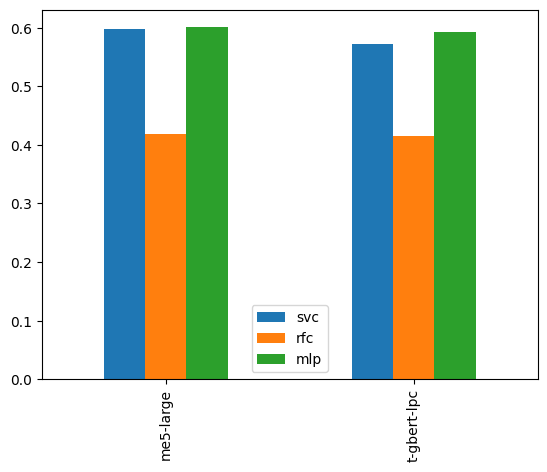

,svc,rfc,mlp
me5-large,0.597146,0.418894,0.600716
t-gbert-lpc,0.5717,0.414804,0.592637


In [17]:
from matplotlib import pyplot as plt

scoring.plot(kind="bar")
plt.show()
scoring